# Lab 3: Convolutional Neural Network

# Training a Classifier


**What about data?**


Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, Pytorch team has created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


   ![cifar10](https://miro.medium.com/max/1648/1*SZnidBt7CQ4Xqcag6rd8Ew.png)




# How to use Dataset and DataLoader?

## Data Loading

For convenience, PyTorch provides a number of utilities to load, preprocess and interact with datasets. These helper classes and functions are found in the torch.utils.data module. The two major concepts here are:



1.   A Dataset, which encapsulates a source of data,
2.   A DataLoader, which is responsible for loading a dataset, possibly in parallel.



New datasets are created by subclassing the torch.utils.data.Dataset class and overriding the \_\_len__ method to return the number of samples in the dataset and the \_\_getitem__ method to access a single value at a certain index. 
​
For example, this would be a simple dataset encapsulating a range of integers:

In [75]:
import math
import torch

class RangeDataset(torch.utils.data.Dataset):
  def __init__(self, start, end, step=1):
    self.start = start
    self.end = end
    self.step = step

  def __len__(self):
    return math.ceil((self.end - self.start) / self.step)

  def __getitem__(self, index):
    value = self.start + index * self.step
    assert value < self.end
    return value

Inside \_\_init__ we would usually configure some paths or change the set of samples ultimately returned. 

In \_\_len__, we specify the upper bound for the index with which \_\_getitem__ may be called.

In \_\_getitem__ we return the actual sample, which could be an image or an audio snippet.

In [76]:
dataset = RangeDataset(0, 10, 2)
print(len(dataset))

5


## DataLoader

To iterate over the dataset we could, in theory, simply have a for i in range loop and access samples via \_\_getitem__. However, it would be much more convenient if the dataset implemented the iterator protocol itself, so we could simply loop over samples with for sample in dataset. Fortunately, this functionality is provided by the DataLoader class. 

A DataLoader object takes a dataset and a number of options that configure the way samples are retrieved. For example, it is possible to load samples in parallel, using multiple processes. For this, the DataLoader constructor takes a num_workers argument. Note that DataLoaders always return batches, whose size is set with the batch_size parameter. Here is a simple example:



In [77]:
dataset = RangeDataset(0, 9)
data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=4, 
    shuffle=True,  # set to True to have the data reshuffled at every epoch
    num_workers=0, # how many subprocesses to use for data loading
    drop_last=True # set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size.
  )

for i, batch in enumerate(data_loader):
  print(i, batch)

0 tensor([4, 1, 7, 8])
1 tensor([3, 2, 6, 5])


Use an iterator

See details [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset)

In [78]:
dataset_iter = iter(dataset)
print(next(dataset_iter))
print(next(dataset_iter))
print(next(dataset_iter))

0
1
2


In [79]:
dataset_iter = iter(dataset)
for i in range(len(dataset)):
  element = next(iter(dataset_iter))
  print(element)

0
1
2
3
4
5
6
7
8


# Training an image classifier


We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10


Using ``torchvision``, it’s extremely easy to load CIFAR10.




In [80]:
%matplotlib inline

In [81]:
import torch
import torchvision
import torchvision.transforms as transforms

## 1- Load and normalizing the CIFAR10 training and test datasets using ``torchvision``

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [82]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [83]:
print('Size of a training batch: {}'.format(trainloader.batch_size))
print('Number of training batches: {}'.format(len(trainloader)))
print('Size of a test batch: {}'.format(testloader.batch_size))
print('Number of test batches: {}'.format(len(testloader)))

Size of a training batch: 100
Number of training batches: 500
Size of a test batch: 100
Number of test batches: 100


See the location of the downloaded data

In [84]:
%pwd
%ls -l
%ls -l ./data
%ls -l ./data/cifar-10-batches-py/

 Le volume dans le lecteur C s'appelle OS
 Le num�ro de s�rie du volume est 5804-9598

 R�pertoire de c:\Users\enzoi\Documents\Polytech\DeepLearning



Fichier introuvable
Le format du param�tre est incorrect - "data".
Le format du param�tre est incorrect - "data".


Let us show some of the training images, for fun.



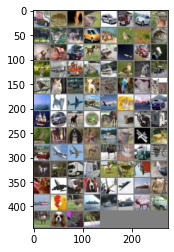

  car  frog horse  bird


In [85]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2- Define a Convolutional Neural Network


Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



The following neural network is created as a module. This is the best way to create a customized neural network (automatic differentiation is still working)

More information on nn.Module [here](https://pytorch.org/tutorials/beginner/nn_tutorial.html#refactor-using-nn-module)

### Question: code the class of the convolutional neural network. 

The network must work as follows:

input -> convolution (kernel 5x5, depth 6) -> relu -> pooling 2D (2x2) -> 

convolution (kernel 5x5, depth 16) -> relu -> pooling 2D (2x2) -> 

fully connected layer with 120 neurons -> relu -> 

fully connected layer with 84 neurons -> relu -> 

fully connected layer with 10 neurons = output

You must replace the keywords "pass" by your code in the following cell.

In [86]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.sigma = nn.ReLU()
        self.f1 = nn.Conv2d(3,6,5)
        self.f2 = nn.MaxPool2d(2,2)
        self.f3 = nn.Conv2d(6,16,5)
        self.f4 = nn.Linear(400,120) 
        self.f5 = nn.Linear(120,84)
        self.f6 = nn.Linear(84,10)
        # self.f7 = nn.Softmax(dim=1)

    def forward(self, x):
        y = self.f2(self.sigma(self.f1(x)))
        y = self.f2(self.sigma(self.f3(y)))
        y = torch.flatten(y,1)
        y = self.sigma(self.f4(y))
        y = self.sigma(self.f5(y))
        y = self.f6(y)
        # y = self.f7(y)
        return y


net = Net()

## 3- Define a Loss function and optimizer


Let's use a Classification Cross-Entropy loss and SGD with momentum.



### Question: define the criterion (choose the appropriate one) and define the optimizer (SGD with an appropriate learning rate).


In [87]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=1e-2,momentum=0.8)

## 4- Train the network



This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



### Question: code the training of the network. Use the autograd mechanism and the optimizer.

Compute and print the running loss each time "Nprint" batches have been processed, i.e., compute and print the average of the loss over the "Nprint" mini-batches.

You must replace the keywords "pass" by your code in the following cell.

In [88]:
Nprint = 100

nb_epoch = 20

for epoch in range(nb_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()
        x,y = data
        y_nn = net(x)
        loss = criterion(y_nn,y)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % Nprint == (Nprint-1):    # print every Nprint mini-batches
            print(f"\tepoch {epoch}\t|\tstep: {i}\t|\t loss: {loss}")
        
print('Finished Training')

	epoch 0	|	step: 99	|	 loss: 2.2987618446350098
	epoch 0	|	step: 199	|	 loss: 2.265345811843872
	epoch 0	|	step: 299	|	 loss: 2.1052846908569336
	epoch 0	|	step: 399	|	 loss: 1.956784963607788
	epoch 0	|	step: 499	|	 loss: 1.828049659729004
	epoch 1	|	step: 99	|	 loss: 1.6433247327804565
	epoch 1	|	step: 199	|	 loss: 1.6719114780426025
	epoch 1	|	step: 299	|	 loss: 1.5955702066421509
	epoch 1	|	step: 399	|	 loss: 1.5368945598602295
	epoch 1	|	step: 499	|	 loss: 1.5220011472702026
	epoch 2	|	step: 99	|	 loss: 1.485792636871338
	epoch 2	|	step: 199	|	 loss: 1.5604263544082642
	epoch 2	|	step: 299	|	 loss: 1.6269314289093018
	epoch 2	|	step: 399	|	 loss: 1.3765602111816406
	epoch 2	|	step: 499	|	 loss: 1.3919150829315186
	epoch 3	|	step: 99	|	 loss: 1.3447849750518799
	epoch 3	|	step: 199	|	 loss: 1.4226281642913818
	epoch 3	|	step: 299	|	 loss: 1.3198797702789307
	epoch 3	|	step: 399	|	 loss: 1.1579803228378296
	epoch 3	|	step: 499	|	 loss: 1.2808979749679565
	epoch 4	|	step: 99	|	 loss:

## 5- Test the network on the test data



We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



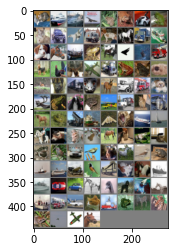

GroundTruth:    cat  ship  ship plane


In [95]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [96]:
outputs = net(images)
print(outputs)
# print(torch.sum(outputs,axis=1))

tensor([[-8.0571e-01, -1.3442e+00, -9.3545e-01,  4.1154e+00, -1.7271e+00,
          3.9496e+00,  1.0397e+00, -2.2028e+00, -2.8966e-01, -7.2906e-01],
        [ 5.5702e+00,  5.4401e+00, -4.1044e+00, -3.0826e+00, -2.1954e+00,
         -4.6336e+00, -6.7746e+00, -5.2291e+00,  9.2349e+00,  4.6734e+00],
        [ 3.3549e+00,  2.8721e+00, -1.9122e-01, -2.0394e+00, -1.6369e+00,
         -2.7278e+00, -3.7145e+00, -1.1083e+00,  3.9056e+00,  1.4689e+00],
        [ 3.1857e+00,  2.2871e+00, -9.9081e-01, -2.0577e-01, -1.8470e+00,
         -2.8474e+00, -3.4847e+00, -3.9668e+00,  2.9709e+00,  2.3103e+00],
        [-5.0178e+00, -1.9008e+00,  3.0523e+00,  5.9300e+00,  4.0471e+00,
          3.0678e+00,  7.4910e+00, -4.7101e+00, -3.3432e+00, -4.6765e+00],
        [-3.2064e+00, -1.2193e+00,  4.3488e-01,  1.8279e+00,  4.0475e-02,
          2.5040e+00,  5.7516e+00, -1.8276e+00, -1.0020e+00, -9.7564e-01],
        [-8.7905e-01,  3.5070e+00, -5.1112e-02,  3.5665e-02, -2.2746e+00,
          9.4151e-01, -2.3105e+0

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



### Question: give the decision for all the images in the code cell above. The decision should be a label belonging to the object "classes".

In [97]:
classes = np.array(classes)

In [98]:
predictions = classes[torch.argmax(outputs,axis=1)]
print(predictions)

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'truck' 'frog' 'cat' 'car'
 'deer' 'truck' 'frog' 'horse' 'truck' 'ship' 'dog' 'horse' 'ship' 'frog'
 'horse' 'bird' 'plane' 'truck' 'deer' 'deer' 'deer' 'plane' 'truck'
 'frog' 'frog' 'bird' 'bird' 'cat' 'truck' 'deer' 'deer' 'car' 'truck'
 'dog' 'deer' 'frog' 'horse' 'frog' 'plane' 'ship' 'cat' 'horse' 'deer'
 'frog' 'deer' 'ship' 'frog' 'frog' 'ship' 'ship' 'dog' 'dog' 'dog' 'cat'
 'horse' 'dog' 'deer' 'bird' 'frog' 'bird' 'plane' 'bird' 'dog' 'horse'
 'bird' 'cat' 'ship' 'ship' 'truck' 'bird' 'bird' 'cat' 'deer' 'ship'
 'ship' 'ship' 'car' 'horse' 'bird' 'horse' 'bird' 'deer' 'ship' 'truck'
 'plane' 'cat' 'plane' 'frog' 'deer' 'frog' 'deer' 'plane' 'bird' 'cat']


Let us look at how the network performs on the whole dataset.



### Question: compute the average accuracy over all the test set.

In [99]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 64 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

What are the classes that performed well, and the classes that did
not perform well




### Question: Compute the average accuracy per class (there are 10 classes).

In [100]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 69.1 %
Accuracy for class car   is: 77.1 %
Accuracy for class bird  is: 58.0 %
Accuracy for class cat   is: 48.2 %
Accuracy for class deer  is: 64.4 %
Accuracy for class dog   is: 47.2 %
Accuracy for class frog  is: 73.4 %
Accuracy for class horse is: 63.9 %
Accuracy for class ship  is: 74.0 %
Accuracy for class truck is: 67.0 %
